<center><font size = "10"> Week 7 - Connections <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 3
<br>Group member1: Laura TESTA
<br>Group member2: Alice ALBRECHT
<br>Group member3: Clara LE DRAOULEC
    
        
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

<font size = "3">For this home work please use the new set of __FIVE__ good morpholgy files corresponding to your group number. 

# Optional: Connect all-to-all with random weights.


<font size='3'>Connect your five cells all to all (unidirectionally) with random weights, as it is done in tutorial 01 of this week, and display the connectivity matrix with the weights.

# <font color= 'red'>Ex 1:</font> Connect your cells considering connection probability

<font size='3'>Connect your five cells as it is done in tutorial 02, considering the following connection probabilities between cell types:
<br> PC - PC: 60 %
<br> PC - Inh: 25 %
<br> Inh - PC: 39 %
<br> Inh - Inh: 37 %

<font size='3'> Show the results on a connection probability matrix and the connection weight matrix between the five cells. 

<font size='3'><font color= 'red'>[1.5 pt]

In [1]:
# Load usefull packages
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import math as m

--No graphics will be displayed.


## Step1: create the class cell

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()

    def build_morphology(self, filename):
        h.load_file("import3d.hoc")
        h.load_file("stdlib.hoc")
        # morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)

    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75

        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        if hasattr(self, "apic"):
            for sec in self.apic:
                sec.insert("hh")
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.dend:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.axon:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

## Step2: Instantiate different cells.

In [3]:
Pyr1 = Cell("Pyr_01.swc", "Pyr1", "Pyr")
Pyr2 = Cell("Pyr_02.swc", "Pyr2", "Pyr")
Pyr3 = Cell("Pyr_03.swc", "Pyr3", "Pyr")
Int1 = Cell("Int_01.swc", "Int1", "Int")
Int2 = Cell("Int_02.swc", "Int2", "Int")
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

In [4]:
for c in cells_Pyr:
    print(
        "%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions"
        % (c.name, len(c.apic), len(c.dend), len(c.soma), len(c.axon))
    )
for c in cells_Int:
    print(
        "%s: %d basal sections, %d soma sections and %d axon senctions"
        % (c.name, len(c.dend), len(c.soma), len(c.axon))
    )

Pyr1: 73 apical sections, 61 basal sections, 1 soma sections and 23 axon senctions
Pyr2: 39 apical sections, 41 basal sections, 1 soma sections and 118 axon senctions
Pyr3: 93 apical sections, 53 basal sections, 1 soma sections and 69 axon senctions
Int1: 21 basal sections, 1 soma sections and 526 axon senctions
Int2: 21 basal sections, 1 soma sections and 526 axon senctions


## Step3: Connect based on connection probabilities

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(
    source,
    target,
    weight=None,
    delay=5,
    source_sec=None,
    source_neurite="axon",
    target_sec=None,
    target_neurite="dend",
):
    rng = np.random.default_rng()

    if weight is None:
        weight = rng.uniform()  # random weight

    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_))  # random dendritic section

    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_))  # random axonal section

    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn)  # store synapse

    netcon = h.NetCon(
        source_neurite_[source_sec](0.5)._ref_v,
        target_syn,
        sec=source_neurite_[source_sec],
    )
    netcon.weight[0] = weight
    netcon.delay = delay

    print(
        "Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]"
        % (
            source.name,
            target.name,
            weight,
            delay,
            source_neurite,
            source_sec,
            target_neurite,
            target_sec,
        )
    )
    return netcon

In [6]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2, 2))
conn_prob_matrix[0, 0] = 0.6   # Pyr to Pyr (PC-PC)
conn_prob_matrix[0, 1] = 0.25  # Pyr to Int (PC-Inh)
conn_prob_matrix[1, 0] = 0.39  # Int to Pyr (Inh-PC)
conn_prob_matrix[1, 1] = 0.37  # Int to Int (Inh-Inh)

In [7]:
# store the weight for each connection - 0 if no connection
weight_matrix = np.zeros((5,5))

netcons = []  # store all netcons

rng = np.random.default_rng()

##### PC-PC #####
# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0, 0]:
    nc = connect(Pyr1, Pyr2)
    netcons.append(nc)
    weight_matrix[1,0] = nc.weight[0]
    
# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0, 0]:
    nc = connect(Pyr2, Pyr1)
    netcons.append(nc)
    weight_matrix[0,1] = nc.weight[0]
    
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0, 0]:
    nc = connect(Pyr1, Pyr3)
    netcons.append(nc)
    weight_matrix[2,0] = nc.weight[0]
    
# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0, 0]:
    nc = connect(Pyr3, Pyr1)
    netcons.append(nc)
    weight_matrix[0,2] = nc.weight[0]
    
# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0, 0]:
    nc = connect(Pyr2, Pyr3)
    netcons.append(nc)
    weight_matrix[2,1] = nc.weight[0]
    
# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0, 0]:
    nc = connect(Pyr3, Pyr2)
    netcons.append(nc)
    weight_matrix[1,2] = nc.weight[0]

    
##### PC-Inh #####
# Connect Pyr1 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    nc = connect(Pyr1, Int1)
    netcons.append(nc)
    weight_matrix[3,0] = nc.weight[0]

# Connect Pyr1 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    nc = connect(Pyr1, Int2)
    netcons.append(nc)
    weight_matrix[4,0] = nc.weight[0]
    
# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    nc = connect(Pyr2, Int1)
    netcons.append(nc)
    weight_matrix[3,1] = nc.weight[0]  

# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    nc = connect(Pyr2, Int2)
    netcons.append(nc)
    weight_matrix[4,1] = nc.weight[0]
    
# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    nc = connect(Pyr3, Int1)
    netcons.append(nc)
    weight_matrix[3,2] = nc.weight[0]
    
# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    nc = connect(Pyr3, Int2)
    netcons.append(nc)
    weight_matrix[4,2] = nc.weight[0]
    
    
##### Inh-PC #####
# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1, 0]:
    nc = connect(Int1, Pyr1, target_neurite="soma")
    netcons.append(nc)
    weight_matrix[0,3] = nc.weight[0]

# Connect Int1 to Pyr2
if rng.random() < conn_prob_matrix[1, 0]:
    nc = connect(Int1, Pyr2, target_neurite="soma")
    netcons.append(nc)
    weight_matrix[1,3] = nc.weight[0]

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1, 0]:
    nc = connect(Int1, Pyr3, target_neurite="soma")
    netcons.append(nc)
    weight_matrix[2,3] = nc.weight[0]
        
# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1, 0]:
    nc = connect(Int2, Pyr1, target_neurite="soma")
    netcons.append(nc)
    weight_matrix[0,4] = nc.weight[0]
    
# Connect Int2 to Pyr2
if rng.random() < conn_prob_matrix[1, 0]:
    nc = connect(Int2, Pyr2, target_neurite="soma")
    netcons.append(nc)
    weight_matrix[1,4] = nc.weight[0]
    
# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1, 0]:
    nc = connect(Int2, Pyr3, target_neurite="soma")
    netcons.append(nc)
    weight_matrix[2,4] = nc.weight[0]
    
    
##### Inh-Inh #####
# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1, 1]:
    nc = connect(Int1, Int2)
    netcons.append(nc)
    weight_matrix[4,3] = nc.weight[0]
    
# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1, 1]:
    nc = connect(Int2, Int1)
    netcons.append(nc)
    weight_matrix[3,4] = nc.weight[0]

Connected cells Pyr2 -> Pyr1 with weight 0.274344 and delay 5, from axon[34] to dend[14]
Connected cells Pyr1 -> Pyr3 with weight 0.752731 and delay 5, from axon[10] to dend[0]
Connected cells Pyr3 -> Pyr1 with weight 0.899745 and delay 5, from axon[64] to dend[42]
Connected cells Pyr3 -> Int1 with weight 0.175594 and delay 5, from axon[9] to dend[10]
Connected cells Int1 -> Pyr1 with weight 0.520793 and delay 5, from axon[397] to soma[0]
Connected cells Int1 -> Pyr2 with weight 0.077868 and delay 5, from axon[372] to soma[0]
Connected cells Int1 -> Pyr3 with weight 0.586139 and delay 5, from axon[227] to soma[0]
Connected cells Int2 -> Pyr1 with weight 0.106345 and delay 5, from axon[240] to soma[0]


<font size='3'>To test connectivity, let's stimulate one neuron and record another

In [8]:
stim_cell = Pyr2
stim_syn = h.ExpSyn(stim_cell.dend[20](0.5))
stim = h.NetStim()  # Make a new stimulator
ncstim = h.NetCon(stim, stim_syn)  # Connect stimulator to synapse

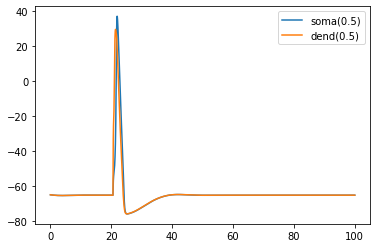

In [9]:
stim.number = 10  # Number of spikes (average)
stim.start = 10  # First spike delay [ms]
ncstim.delay = 1  # NetCon ms
ncstim.weight[0] = 0.8  # NetCon weight

recording_cell = Pyr1

soma_v = h.Vector().record(recording_cell.soma[0](0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend[20](0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(100)
plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

## Step4: Connection probability matrix (between cell types)

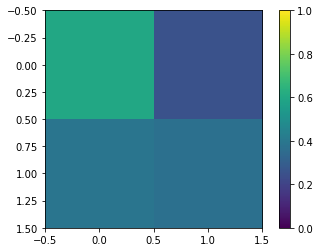

In [10]:
plt.imshow(conn_prob_matrix, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar()

## Step5: Connection weight matrix (between cells)

In [11]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

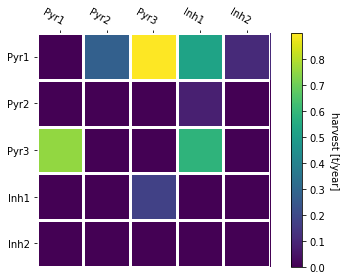

In [12]:
fig, ax = plt.subplots()

im, cbar = heatmap(
    weight_matrix,
    ["Pyr1", "Pyr2", "Pyr3", "Inh1", "Inh2"],
    ["Pyr1", "Pyr2", "Pyr3", "Inh1", "Inh2"],
    ax=ax,
    cmap="viridis",
    cbarlabel="harvest [t/year]",
)

fig.tight_layout()

We can notice that there are many weights equal to 0. This is due to the absence of connection. We play with the probabilities to create a connection between two cells and if there is no connection then we leave a weight of 0. Also we made the choice not to put a seed so it is possible to rerun the boxes above and find other results corresponding to other connections.

# <font color= 'red'>Ex 2:</font>  Distribution of contacts: Convergence Matrix

<font size='3'>

Considering the following mean contact points between cell types: 
- PC_axon - PC_basal: 6
- PC_axon - PC_apical: 1
- PC_axon - Inh_basal: 2
- Inh_axon - PC_soma: 4
- Inh_axon - PC_basal: 3
- Inh_axon - Inh_soma: 5
- Inh_axon - Inh_basal: 1


Following and expanding the implementation from Tutorial 3: connect the neurons by selecting the specific contact points. The connections should follow a __normal distribution__ with the mean value per connection specified by the above values. 
Show the results on a __convergence__ matrix (how many contacts each of the cells receives from the others). 

Stimulate the connected neurons and briefly interpret the relationship between the number of connections and your simulation results.

<font color= 'red'><font size='3'>[2 pts] 

***Note : In the previous exercice we already define the class "Cell", import the 5 given cells (Pyr1, Pyr2, Pyr3, Int1, Int2) and apply the connection probabilities between cell types.***

## Step6: Connect with morphological distribution of contacts

In [13]:
# specify expected number of contacts between cell types, considering target neurite
# 0:soma, 1:dend(basal), 2:apic(apical)
expected_contacts = np.zeros((2, 2, 3), dtype=int)

expected_contacts[0, 0, 1] = 6  # Pyr to Pyr (dend)
expected_contacts[0, 0, 2] = 1  # Pyr to Pyr (apic)

expected_contacts[0, 1, 1] = 2  # Pyr to Int (dend)

expected_contacts[1, 0, 0] = 4  # Int to Pyr (soma)
expected_contacts[1, 0, 1] = 3  # Int to Pyr (dend)

expected_contacts[1, 1, 0] = 5  # Int to Int (soma)
expected_contacts[1, 1, 1] = 1  # Int to Int (dend)

In [14]:
expected_contacts

array([[[0, 6, 1],
        [0, 2, 0]],

       [[4, 3, 0],
        [5, 1, 0]]])

In [15]:
# generate number of contacts per cell type, by selecting them from a normal distribution
# in which the mean is the expected_contacts value

netcons = []  # store all netcons
rng = np.random.default_rng()

##### PC-PC #####

# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Pyr1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Pyr1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Pyr2, target_neurite=neurite)
            netcons.append(nc)
            
            
##### PC-Inh ##### NO APICAL IN INHIBITORY CELLS

# Connect Pry1 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pry1 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Int2, target_neurite=neurite)
            netcons.append(nc)
               
# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Int1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Int2, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Int2, target_neurite=neurite)
            netcons.append(nc)           

            
##### Inh-PC #####

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pry2
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int2 to Pry2
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Pyr2, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Pyr3, target_neurite=neurite)
            netcons.append(nc)


##### Inh-Inh ##### NO APICAL IN INHIBITORY CELLS

# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Int2, target_neurite=neurite)
            netcons.append(nc)


# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Int1, target_neurite=neurite)
            netcons.append(nc)

Connected cells Pyr1 -> Pyr2 with weight 0.141379 and delay 5, from axon[13] to dend[1]
Connected cells Pyr1 -> Pyr2 with weight 0.888844 and delay 5, from axon[6] to dend[12]
Connected cells Pyr1 -> Pyr2 with weight 0.44658 and delay 5, from axon[1] to dend[24]
Connected cells Pyr1 -> Pyr2 with weight 0.581882 and delay 5, from axon[12] to dend[19]
Connected cells Pyr1 -> Pyr2 with weight 0.270328 and delay 5, from axon[8] to dend[40]
Connected cells Pyr1 -> Pyr2 with weight 0.858686 and delay 5, from axon[7] to dend[31]
Connected cells Pyr2 -> Pyr1 with weight 0.943245 and delay 5, from axon[50] to dend[2]
Connected cells Pyr2 -> Pyr1 with weight 0.866721 and delay 5, from axon[10] to dend[3]
Connected cells Pyr2 -> Pyr1 with weight 0.0773086 and delay 5, from axon[60] to dend[18]
Connected cells Pyr2 -> Pyr1 with weight 0.105636 and delay 5, from axon[18] to dend[47]
Connected cells Pyr2 -> Pyr1 with weight 0.15423 and delay 5, from axon[85] to dend[48]
Connected cells Pyr2 -> Pyr1 

## Step7: Convergence Matrix: how many contacts a certain cell makes with the others

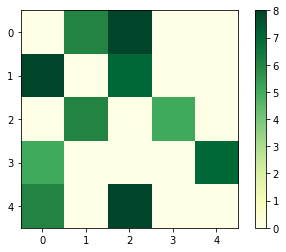

In [16]:
contacts_matrix = np.zeros((5, 5))
cellnames = [x.name for x in cells]

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    contacts_matrix[ipre, ipos] += 1

plt.imshow(contacts_matrix, cmap="YlGn")
plt.colorbar()

<font size='3'>To test connectivity, let's stimulate one neuron and record another

In [17]:
stim_cell = Pyr2
stim_syn = h.ExpSyn(stim_cell.dend[20](0.5))
stim = h.NetStim()  # Make a new stimulator
ncstim = h.NetCon(stim, stim_syn)  # Connect stimulator to synapse

<font size='3'>You can play with the parameters below and rerun to see the change in the voltage traces

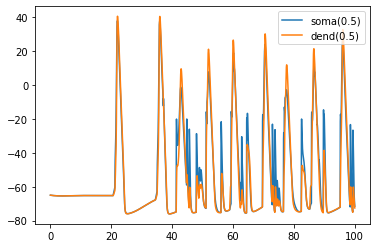

In [18]:
stim.number = 10  # Number of spikes (average)
stim.start = 10  # First spike delay [ms]
ncstim.delay = 1  # NetCon ms
ncstim.weight[0] = 0.8  # NetCon weight

recording_cell = Pyr1

soma_v = h.Vector().record(recording_cell.soma[0](0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend[20](0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(100)
plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

We chose to stimluate the pyramidal cell 2 and record the pyramidal cell 1. As we see on the convergence plot, the maximal number of contact between those two cells is 8 divided between the dendrites and apical part. Indeed, when we stimluate the pre-synaptic cell, we observe that the signal is propagating through the soma and the dendrite of the post synaptic cell. 
The relationship between the number of onnection and the stimulation results is the following: there is a least one connection since we clearly se that the post-synaptic cell is also depolarizing. Furthermore, since there are a lot of contacts on the dendrites, we observe an increase of number of AP, compared for example with a synpatic connection with fewer number of contacts as shown below. Additionally, we observe that all the s of the post synpatic cell caused by the pre synpatic cell do not lead to an AP, but they still contribute to increase the potential of the cell at the soma.

In [46]:
stim_cell = Pyr3
stim_syn = h.ExpSyn(stim_cell.dend[20](0.5))
stim = h.NetStim()  # Make a new stimulator
ncstim = h.NetCon(stim, stim_syn)  # Connect stimulator to synapse

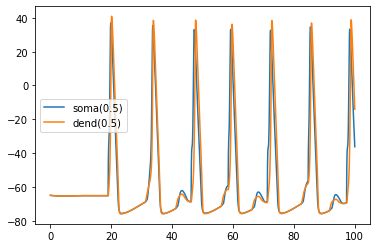

In [48]:
stim.number = 10  # Number of spikes (average)
stim.start = 10  # First spike delay [ms]
ncstim.delay = 1  # NetCon ms
ncstim.weight[0] = 0.8  # NetCon weight

recording_cell = Pyr2

soma_v = h.Vector().record(recording_cell.soma[0](0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend[20](0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(100)
plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

# <font color='red'>Ex 3:</font> Real Connectivity Rules

<font size='3'>
    
Read the articles uploaded with this homework (Markram_1997.pdf and Gupta_2000.pdf). 

Imagine that you have to build a network with your five cells (3 pyramidals and 2 GABAergic interneurons) from the rat somatosensory cortex. Extract from the papers the data that you would need to connect your cells (connectivity rules). 
Enumerate the data chosen to connect your cells. Make sure to read the papers thoroughly and extract all of the connectivity information.  
    
Using and modifying (if needed) the code from the tutorials, connect your five cells in a more biological way using the connectivity rules found in the papers. Visualize the results of the resulting connectivity.    
    
    
<font size='3'><font color= 'red'>[2.5 pts]

### Information that we extract from Markram's paper:
    

### Information that we extract from Gupta's paper:

In this paper, we focus on connections with GABAergic neurons. What they found in the study is that the F2 GABAergic synpatic connection was the  most common type. Therefore, we will use the values corresponding to F2 GABAergic synpatic connections.

1. Connection probabilities (these values are taken from table 1):
    - IN TO IN : 58.3% = 0.583
    - IN TO PC : 76.3%  = 0.73
    
    Because we have no information about PC-IN nor PC-PC connections, we use values from the previous exercise.      
    
2. Number of contacs. We know that there are 16 synapses for F2 connections. Different types of cells forming F2 connections are described in the paper, but we decided to focus on one of them such as Martinotti cells. 30% of the synpases they can do with PC cells are directed to their dendrites. we assume that the remaining 70% are directed to the soma.
    - IN_AXON- PC_SOMA: 16 * 70% = 11.2
    - IN_AXON - PC_BASAL: 16 * 30% = 4.8
    Again, because we couldn't find any other information about PC connecitons, we use previous values.


In [49]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))
conn_prob_matrix[0,0] = 0.7 # PC to PC
conn_prob_matrix[0,1] = 0.19 # PC to Inh
conn_prob_matrix[1,0] = 0.763 # Inh to PC
conn_prob_matrix[1,1] = 0.583 # Inh to Inh

In [50]:
# specify expected number of contacts between cell types, considering target neurite
expected_contacts = np.zeros((2,2,3), dtype=int)

expected_contacts[0,0,0] = 0 # Pc to Pc (soma)
expected_contacts[0,0,1] = 3.456 # Pc to Pc (basal)
expected_contacts[0,0,2] = 1.485 # Pc to Pc (apic)

expected_contacts[1,0,0] = 11.2 # Inh to Pc  (soma)
expected_contacts[1,0,1] = 4.8  # Inh to Pc  (basal)
expected_contacts[1,0,2] = 0 # Inh to Pc  (apic)

expected_contacts[0,1,0] = 0 # Pc to Inh (soma)
expected_contacts[0,1,1] = 4 # Pc to Inh (basal)

expected_contacts[1,1,0] = 3.8 # Inh to Inh (soma)
expected_contacts[1,1,1] = 1.9 # Inh to Inh (basal)

In [53]:
# generate number of contacts per cell type, by selecting them from a normal distribution
# in which the mean is the expected_contacts value

netcons = []  # store all netcons
rng = np.random.default_rng()

##### PC-PC #####

# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Pyr1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Pyr1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Pyr2, target_neurite=neurite)
            netcons.append(nc)
            
            
##### PC-Inh ##### NO APICAL IN INHIBITORY CELLS

# Connect Pry1 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pry1 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr1, Int2, target_neurite=neurite)
            netcons.append(nc)
               
# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Int1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr2, Int2, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Pyr3, Int2, target_neurite=neurite)
            netcons.append(nc)           

            
##### Inh-PC #####

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pry2
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[1, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int2 to Pry2
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 1, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Pyr2, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1, 0]:
    for i, neurite in enumerate(["soma", "dend", "apic"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Pyr3, target_neurite=neurite)
            netcons.append(nc)


##### Inh-Inh ##### NO APICAL IN INHIBITORY CELLS

# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int1, Int2, target_neurite=neurite)
            netcons.append(nc)


# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1, 1]:
    for i, neurite in enumerate(["soma", "dend"]):
        contacts = expected_contacts[0, 0, i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0, contacts):
            nc = connect(Int2, Int1, target_neurite=neurite)
            netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.137041 and delay 5, from axon[109] to dend[27]
Connected cells Pyr2 -> Pyr1 with weight 0.736302 and delay 5, from axon[63] to dend[12]
Connected cells Pyr2 -> Pyr1 with weight 0.222598 and delay 5, from axon[109] to dend[39]
Connected cells Pyr3 -> Pyr1 with weight 0.321799 and delay 5, from axon[16] to dend[1]
Connected cells Pyr3 -> Pyr1 with weight 0.203636 and delay 5, from axon[46] to dend[14]
Connected cells Pyr3 -> Pyr1 with weight 0.132649 and delay 5, from axon[63] to dend[21]
Connected cells Pyr3 -> Pyr1 with weight 0.665017 and delay 5, from axon[62] to apic[55]
Connected cells Pyr2 -> Pyr3 with weight 0.337046 and delay 5, from axon[67] to dend[33]
Connected cells Pyr2 -> Pyr3 with weight 0.0127064 and delay 5, from axon[72] to dend[8]
Connected cells Pyr2 -> Pyr3 with weight 0.23176 and delay 5, from axon[28] to apic[25]
Connected cells Pyr3 -> Pyr2 with weight 0.682761 and delay 5, from axon[53] to dend[6]
Connected cells Pyr3 -

### Convergence matrix

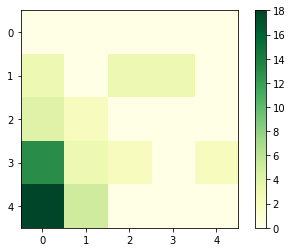

In [55]:

contacts_matrix = np.zeros((5,5))
cellnames = [x.name for x in cells]

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    contacts_matrix[ipre,ipos] += 1

plt.imshow(contacts_matrix, cmap="YlGn")
plt.colorbar()